In [1]:
import os
import glob
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
conf_list = ["AAAI", "CVPR", "ICML", "KDD", "NeurIPS"]
conf_map = {name: i for i, name in enumerate(conf_list)}
root_dir = "CCFA TXT"
batch_size = 8
num_epochs = 100

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

使用设备: cuda


In [4]:
entity_df = pd.read_csv("entity_embeddings.csv", index_col=0)
entity_emb_dict = entity_df.to_dict(orient="index")
kg_dim = len(next(iter(entity_emb_dict.values())))

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()  # 推理阶段禁用 dropout

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
class PaperDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.text_features = []
        self.labels = []

        for conf in conf_list:
            if conf == "NeurIPS":
                txt_paths = glob.glob(os.path.join(root_dir, "NeurlPS2023", "txt", "*.txt"))
                txt_paths += glob.glob(os.path.join(root_dir, "NeurlPS2024", "txt", "*.txt"))
            else:
                txt_paths = glob.glob(os.path.join(root_dir, conf, "txt", "*.txt"))

            print(f"[{conf}] 读取文件数: {len(txt_paths)}")

            for path in txt_paths:
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()

                paper_id = os.path.basename(path).replace(".txt", "")
                label = conf_map[conf]

                # 提取文本特征
                tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to(device)
                with torch.no_grad():
                    text_emb = bert_model(**tokens).pooler_output.squeeze(0).cpu()

                self.samples.append(paper_id)
                self.text_features.append(text_emb)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paper_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        text_emb = self.text_features[idx].to(device)

        if paper_id in entity_emb_dict:
            kg_vector = list(entity_emb_dict[paper_id].values())
            kg_emb = torch.tensor(kg_vector, dtype=torch.float)
        else:
            kg_emb = torch.zeros(kg_dim, dtype=torch.float)

        kg_emb = kg_emb.to(device)
        return torch.cat([text_emb, kg_emb]), label.to(device)


In [7]:
class PaperClassifier(nn.Module):
    def __init__(self, kg_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 + kg_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
dataset = PaperDataset(root_dir)

[AAAI] 读取文件数: 200
[CVPR] 读取文件数: 199
[ICML] 读取文件数: 200
[KDD] 读取文件数: 17
[NeurIPS] 读取文件数: 100


In [9]:
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

# 划分数据集
train_set, test_set = random_split(dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
model = PaperClassifier(kg_dim=kg_dim, num_classes=len(conf_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    # 训练
    model.train()
    total_train_loss = 0
    correct_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (logits.argmax(1) == y).sum().item()

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_set)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # 测试
    model.eval()
    total_test_loss = 0
    correct_test = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            loss_test = criterion(outputs, y_test)
            total_test_loss += loss_test.item()
            correct_test += (outputs.argmax(1) == y_test).sum().item()

    test_loss = total_test_loss / len(test_loader)
    test_acc = correct_test / len(test_set)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/100 | Train Loss: 1.4584, Train Acc: 0.3094 | Test Loss: 1.4157, Test Acc: 0.3472
Epoch 2/100 | Train Loss: 1.4064, Train Acc: 0.3182 | Test Loss: 1.4147, Test Acc: 0.3194
Epoch 3/100 | Train Loss: 1.3740, Train Acc: 0.3636 | Test Loss: 1.3670, Test Acc: 0.4097
Epoch 4/100 | Train Loss: 1.3491, Train Acc: 0.4231 | Test Loss: 1.3359, Test Acc: 0.3889
Epoch 5/100 | Train Loss: 1.3194, Train Acc: 0.4231 | Test Loss: 1.3625, Test Acc: 0.3958
Epoch 6/100 | Train Loss: 1.2991, Train Acc: 0.4650 | Test Loss: 1.3151, Test Acc: 0.4097
Epoch 7/100 | Train Loss: 1.2782, Train Acc: 0.4895 | Test Loss: 1.2956, Test Acc: 0.4375
Epoch 8/100 | Train Loss: 1.2593, Train Acc: 0.4545 | Test Loss: 1.2907, Test Acc: 0.4514
Epoch 9/100 | Train Loss: 1.2349, Train Acc: 0.4983 | Test Loss: 1.2655, Test Acc: 0.4306
Epoch 10/100 | Train Loss: 1.2252, Train Acc: 0.4948 | Test Loss: 1.2399, Test Acc: 0.4722
Epoch 11/100 | Train Loss: 1.1953, Train Acc: 0.5140 | Test Loss: 1.2444, Test Acc: 0.4792
Epoch 12

In [12]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n=== 验证集评估结果 ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



=== 验证集评估结果 ===
Accuracy:  0.6181
Precision: 0.6907
Recall:    0.6872
F1 Score:  0.6801


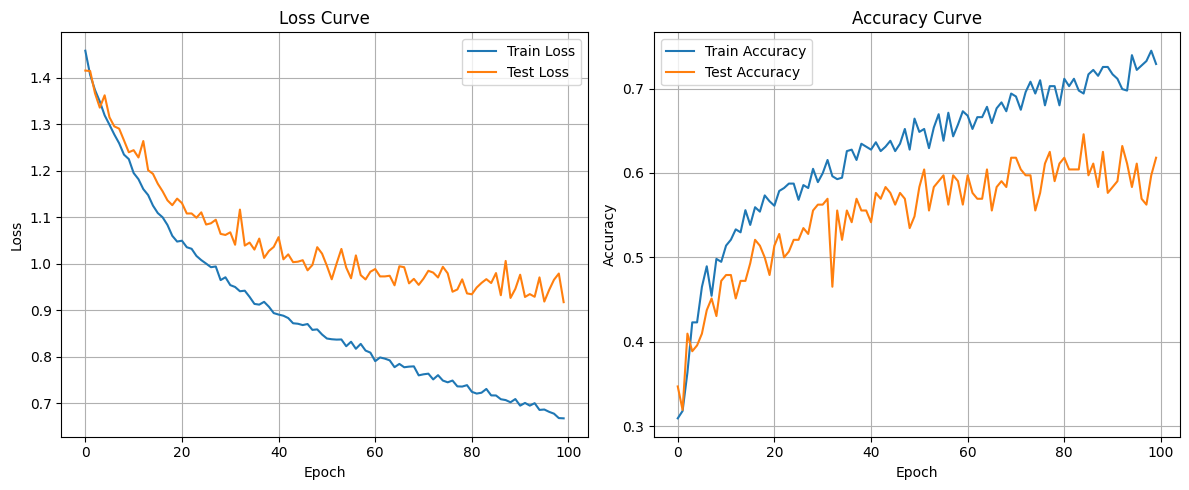

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_testing_curves.png")
plt.show()